In [3]:
#import libraries
import numpy as np
import pandas as pd
from scipy import signal 
from scipy.signal import butter, sosfilt, sosfreqz
import pyriemann.utils.mean as rie_mean
import scipy.io as sio
from scipy.special import binom
from scipy import linalg
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC

In [4]:
#loaddata into training and testing set
def get_data(subject,training,PATH):
    NO_channels = 22
    NO_tests = 6*48 
    Window_Length = 7*250 
    class_return = np.zeros(NO_tests)
    data_return = np.zeros((NO_tests,NO_channels,Window_Length))
    NO_valid_trial = 0
    if training:
        a = sio.loadmat(PATH+'A0'+str(subject)+'T.mat')
    else:
        a = sio.loadmat(PATH+'A0'+str(subject)+'E.mat')
    a_data = a['data']
    for ii in range(0,a_data.size):
        a_data1 = a_data[0,ii]
        a_data2=[a_data1[0,0]]
        a_data3=a_data2[0]
        a_X = a_data3[0]
        a_trial = a_data3[1]
        a_y = a_data3[2]
        a_fs = a_data3[3]
        a_classes = a_data3[4]
        a_artifacts = a_data3[5]
        a_gender = a_data3[6]
        a_age = a_data3[7]
        for trial in range(0,a_trial.size):
            if(a_artifacts[trial]==0):
                data_return[NO_valid_trial,:,:] = np.transpose(a_X[int(a_trial[trial])
                                            :(int(a_trial[trial])+Window_Length),:22])
                class_return[NO_valid_trial] = int(a_y[trial])
                NO_valid_trial +=1


    return data_return[0:NO_valid_trial,:,:], class_return[0:NO_valid_trial]

In [5]:
#variable decleration
NO_splits = 5
fs = 250
NO_channels = 22
NO_csp = 24
bw = np.array([2,4,8,16,32])
NO_tests = 6*48 
Window_Length = 7*250 
forder= 2

In [6]:
#filterfunction - bandpass filtering
def load_filterbank(bandwidth,fs, order = 4, max_freq = 40,ftype = 'butter'):
    f_band_nom = load_bands(bandwidth,fs,max_freq) 
    n_bands = f_band_nom.shape[0]
    if ftype == 'butter': 
        filter_bank = np.zeros((n_bands,order,6))
    elif ftype == 'fir':
        filter_bank = np.zeros((n_bands,order))
    for band_idx in range(n_bands):
        if ftype == 'butter': 
            filter_bank[band_idx] = butter(order, f_band_nom[band_idx], analog=False, btype='band', output='sos')
        elif ftype == 'fir':
            filter_bank[band_idx] = signal.firwin(order,f_band_nom[band_idx],pass_zero=False)
    return filter_bank

#load frequency bands to filter noise and get specific data
def load_bands(bandwidth,f_s,max_freq = 40):
    f_bands = np.zeros((99,2)).astype(float)
    band_counter = 0
    for bw in bandwidth:
        startfreq = 4
        while (startfreq + bw <= max_freq): 
            f_bands[band_counter] = [startfreq, startfreq + bw]
            if bw ==1: # do 1Hz steps
                startfreq = startfreq +1
            elif bw == 2: # do 2Hz steps
                startfreq = startfreq +2 
            else : # do 4 Hz steps if Bandwidths >= 4Hz
                startfreq = startfreq +4
            band_counter += 1 

# convert array to normalized frequency 
    f_bands_nom = 2*f_bands[:band_counter]/f_s
    return f_bands_nom

def butter_fir_filter(signal_in,filter_coeff):
    if filter_coeff.ndim == 2: # butter worth 
        return sosfilt(filter_coeff, signal_in)
    elif filter_coeff.ndim ==1: # fir filter 
        NO_channels ,NO_samples = signal_in.shape 
        sig_filt = np.zeros((NO_channels ,NO_samples))
        for channel in range(0,NO_channels):
            sig_filt[channel] = signal.convolve(signal_in[channel,:],filter_coeff,mode='same') # signal has same size as signal_in (centered)
        return sig_filt

In [7]:
#decleration for CSPfeature extraction
filter_bank=load_filterbank(bw,fs,forder,40,'butter')
time_windows_flt = np.array([[2.5,3.5],[3,4],[3.5,4.5],[4,5],[4.5,5.5],[5,6],[2.5,4.5],[3,5],[3.5,5.5],[4,6],[2.5,6]])*fs
time_windows = time_windows_flt.astype(int)
NO_bands = filter_bank.shape[0]
NO_time_windows = int(time_windows.size/2)
NO_features = NO_csp*NO_bands*NO_time_windows

In [8]:
#Eigen value generation
def gevd(x1,x2,no_pairs):
    ev,vr= linalg.eig(x1,x2,right=True) 
    evAbs = np.abs(ev)
    sort_indices = np.argsort(evAbs)
    chosen_indices = np.zeros(2*no_pairs).astype(int)
    chosen_indices[0:no_pairs] = sort_indices[0:no_pairs]
    chosen_indices[no_pairs:2*no_pairs] = sort_indices[-no_pairs:]
    w = vr[:,chosen_indices] # ignore nan entries 
    return w

In [9]:
#covariance matrix for csp features
def csp_one_one(cov_matrix,NO_csp,NO_classes):
    N, _ = cov_matrix[0].shape 
    n_comb = binom(NO_classes,2)
    NO_filtpairs = int(NO_csp/(n_comb*2))
    w = np.zeros((N,NO_csp))
    kk = 0 # internal counter 
    for cc1 in range(0,NO_classes):
        for cc2 in range(cc1+1,NO_classes):
            w[:,NO_filtpairs*2*(kk):NO_filtpairs*2*(kk+1)] = gevd(cov_matrix[cc1], cov_matrix[cc2],NO_filtpairs)
            kk +=1
    return w

def generate_projection(data,class_vec,NO_csp,filter_bank,time_windows,NO_classes=4): 
#generate spatial filters for every timewindow and frequency band
    time_windows = time_windows.reshape((-1,2))
    NO_bands = filter_bank.shape[0]
    NO_time_windows = len(time_windows[:,0])
    NO_channels = len(data[0,:,0])
    NO_trials = class_vec.size

# Initialize spatial filter: 
    w = np.zeros((NO_time_windows,NO_bands,NO_channels,NO_csp))
# iterate through all time windows 
    for t_wind in range(0,NO_time_windows):
# get start and end point of current time window 
        t_start = time_windows[t_wind,0]
        t_end = time_windows[t_wind,1]

# iterate through all frequency bandwidths 
        for subband in range(0,NO_bands): 

            cov = np.zeros((NO_classes,NO_trials, NO_channels,NO_channels))
            cov_avg = np.zeros((NO_classes,NO_channels,NO_channels))
            cov_cntr = np.zeros(NO_classes).astype(int) # counter of class occurence 
#go through all trials and estimate covariance matrix of every class 
            for trial in range(0,NO_trials):
#frequency band of every channel
                data_filter = butter_fir_filter(data[trial,:,t_start:t_end], 
                                                filter_bank[subband])
                cur_class_idx = int(class_vec[trial]-1)

# caclulate current covariance matrix 
                cov[cur_class_idx,cov_cntr[cur_class_idx],:,:] = np.dot(data_filter,
                                                        np.transpose(data_filter))

# update covariance matrix and class counter 
                cov_cntr[cur_class_idx] += 1

# calculate average of covariance matrix 
            for clas in range(0,NO_classes):
                cov_avg[clas,:,:] = rie_mean.mean_covariance(
                    cov[clas,:cov_cntr[clas],:,:], metric = 'euclid')
            w[t_wind,subband,:,:] = csp_one_one(cov_avg,NO_csp,NO_classes) 
    return w

In [10]:
def extract_feature(data,w,filter_bank,time_windows):
    NO_csp = len(w[0,0,0,:])
    time_windows = time_windows.reshape((-1,2))
    NO_time_windows = int(time_windows.size/2)
    NO_bands = filter_bank.shape[0]
    NO_trials = len(data[:,0,0])
    NO_features = NO_csp*NO_bands*NO_time_windows
    
    feature_mat = np.zeros((NO_trials, NO_time_windows,NO_bands,NO_csp))

# initialize feature vector 
    feat = np.zeros((NO_time_windows,NO_bands,NO_csp))

# go through all trials 
    for trial in range(0,NO_trials):

# iterate through all time windows 
        for t_wind in range(0,NO_time_windows):
# get start and end point of current time window 
            t_start = time_windows[t_wind,0]
            t_end = time_windows[t_wind,1]

            for subband in range(0,NO_bands):
#Apply spatial Filter to data 
                cur_data_s = np.dot(np.transpose(w[t_wind,subband]),data[trial,:,t_start:t_end])
    
#frequency filtering  
                cur_data_f_s = butter_fir_filter(cur_data_s,filter_bank[subband])

# calculate variance of all channels 
                feat[t_wind,subband] = np.var(cur_data_f_s,axis=1)

# calculate log10 of normalized feature vector 
        for subband in range(0,NO_bands):
            feat[:,subband] = np.log10(feat[:,subband])#/np.sum(feat[:,subband]))

# store feature in list 
        feature_mat[trial,:,:,:] = feat
    return np.reshape(feature_mat,(NO_trials,-1))

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [13]:
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

In [44]:
#SVC USING CSP - Support vector classifier
for i in range(1,10):
    print("Subject : ",i)
    #load data
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    #extract csp features
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    #standardize data to get all the features into 1 scale for better results
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    #SVC algorithm to classify the datapoints
    clf = LinearSVC(C = 0.05, intercept_scaling=1, loss='hinge', max_iter=1000,multi_class='ovr', penalty='l2', random_state=1, tol=0.00001)
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    print("Precision : ",precision_score(Y_test, y_pred,average=None))
    print("Recall : ",recall_score(Y_test, y_pred,average=None))
    print("Kappa score : ",cohen_kappa_score(y_pred,Y_test))



Subject :  1
Accuracy :  0.8754448398576512
Precision :  [0.96825397 0.89473684 0.81428571 0.83333333]
Recall :  [0.85915493 0.97142857 0.82608696 0.84507042]
Kappa score :  0.8339411744841793
Subject :  2
Accuracy :  0.6289752650176679
Precision :  [0.56451613 0.54237288 0.75294118 0.61038961]
Recall :  [0.49295775 0.45070423 0.92753623 0.65277778]
Kappa score :  0.5054835327597398
Subject :  3
Accuracy :  0.8388278388278388
Precision :  [0.88888889 0.93055556 0.75       0.78787879]
Recall :  [0.8358209  0.95714286 0.79411765 0.76470588]
Kappa score :  0.7850547562808675
Subject :  4
Accuracy :  0.6622807017543859
Precision :  [0.62295082 0.62903226 0.76       0.65454545]
Recall :  [0.6440678  0.68421053 0.6440678  0.67924528]
Kappa score :  0.5496845021289694
Subject :  5
Accuracy :  0.7210144927536232
Precision :  [0.74324324 0.68421053 0.75471698 0.71232877]
Recall :  [0.78571429 0.8        0.55555556 0.75362319]
Kappa score :  0.628481023722532
Subject :  6
Accuracy :  0.539534883

In [68]:
#plot ROC curve
import seaborn as sns
def plot_multiclass_roc(j,clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    i=j
    plt.savefig('SVC Subject %i.png' % (i))
    plt.show()


ROC_AUC Score :  0.9767609248594183


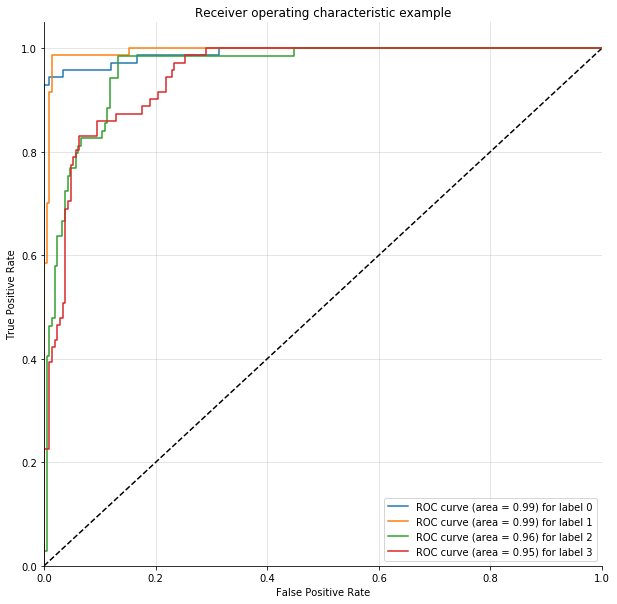

ROC_AUC Score :  0.8438036529894446


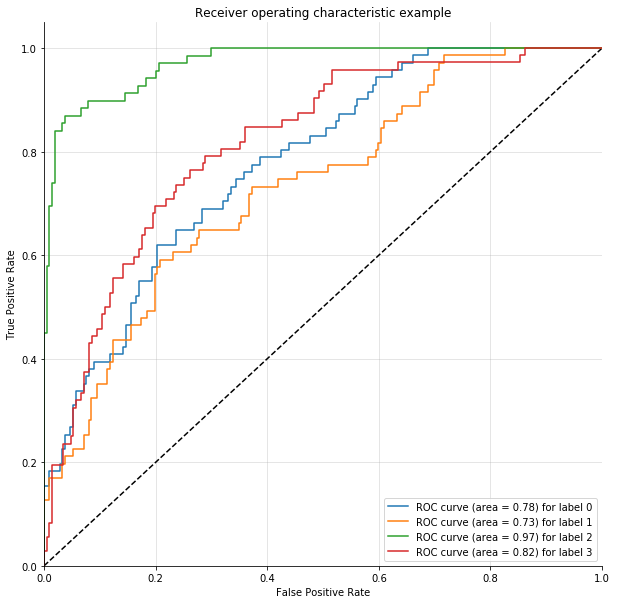

ROC_AUC Score :  0.9702090020853347


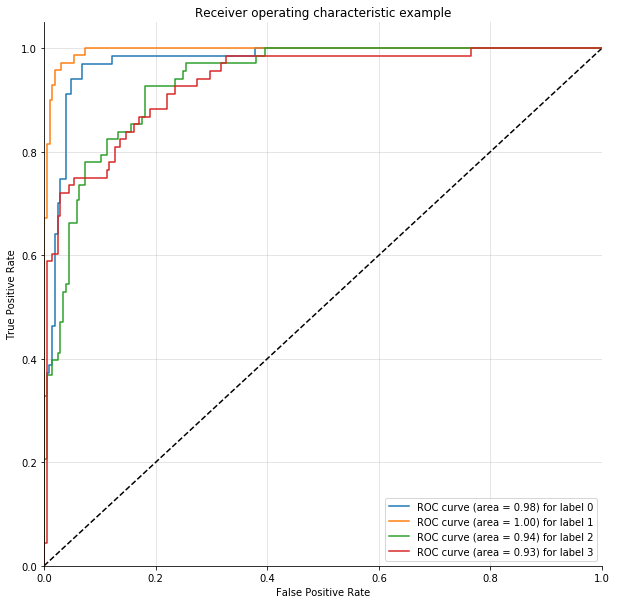

ROC_AUC Score :  0.9083095160125528


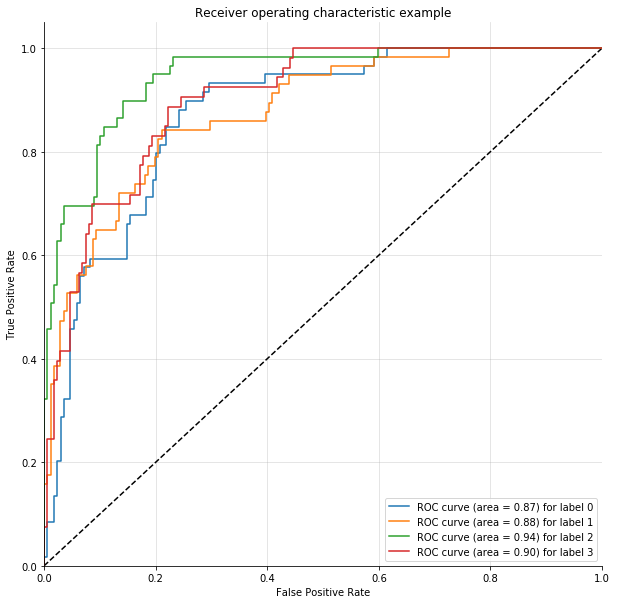

ROC_AUC Score :  0.9195550527997756


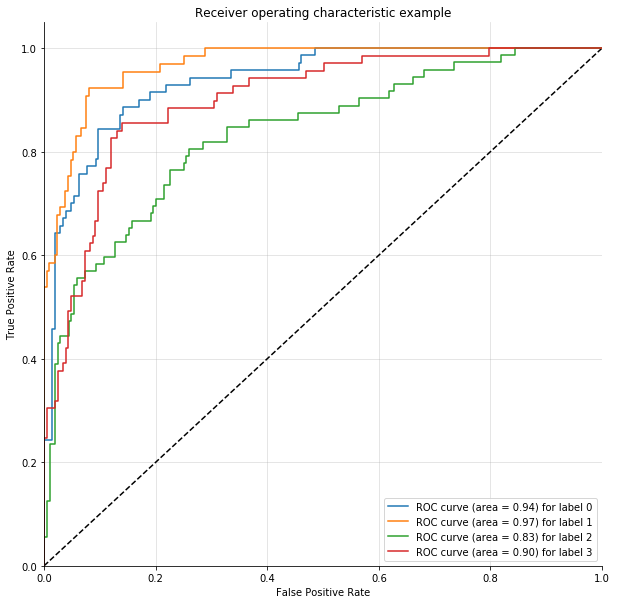

ROC_AUC Score :  0.8033255030929451


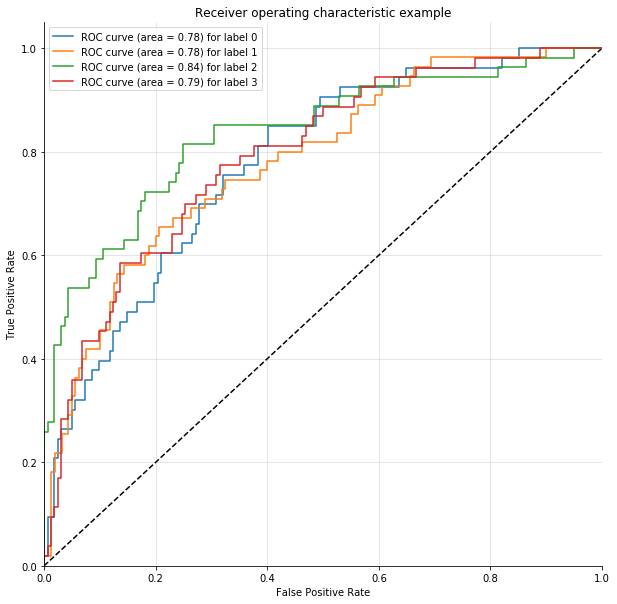

ROC_AUC Score :  0.9957332124894872


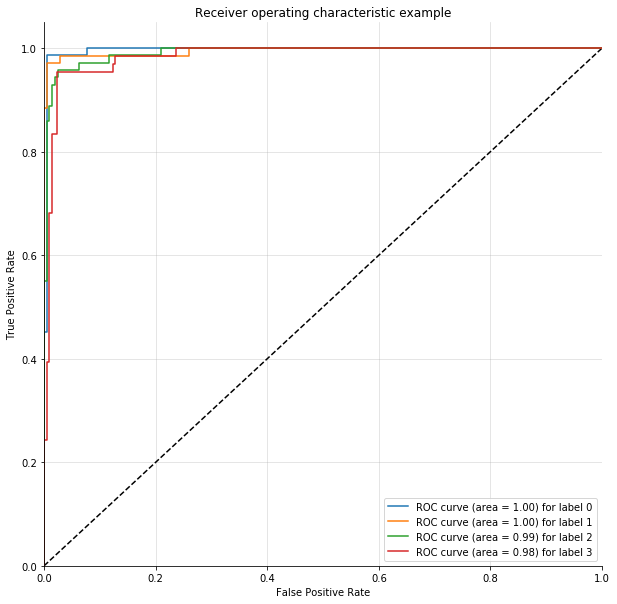

ROC_AUC Score :  0.9790346557848282


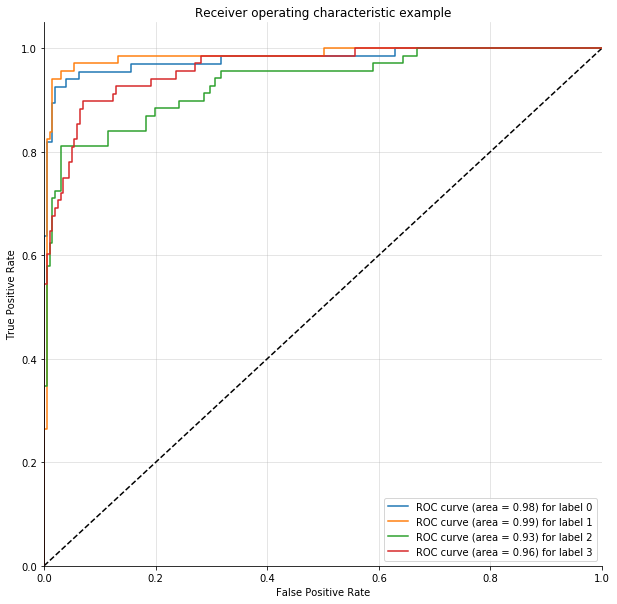

ROC_AUC Score :  0.9659749670619237


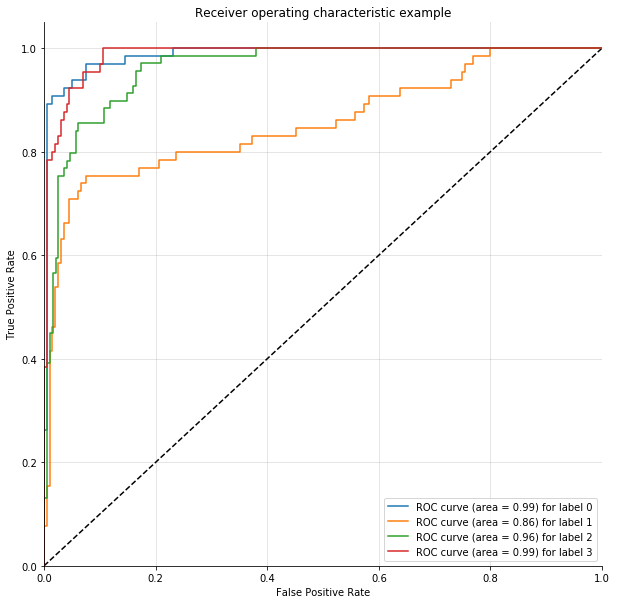

In [76]:
#SVC USING CSP
for i in range(1,10):
    
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    classifier = SVC(kernel='linear',probability=True)
    probas_ = classifier.fit(X_train, Y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
    print("ROC_AUC Score : ",roc_auc_score(Y_test, probas_, multi_class="ovo",
                                     average="weighted"))
    plot_multiclass_roc(i,classifier, X_test, Y_test, n_classes=4, figsize=(10, 10))




In [77]:
import seaborn as sns
def plot_multiclass_roc(j,clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    i=j
    plt.savefig('Random Forest Subject %i.png' % (i))
    plt.show()


Subject :  1
Accuracy :  0.8718861209964412
Precision :  [0.95588235 0.94366197 0.8        0.79220779]
Recall :  [0.91549296 0.95714286 0.75362319 0.85915493]
Kappa score :  0.8291533667730658
ROC_AUC Score :  0.9822759376760156


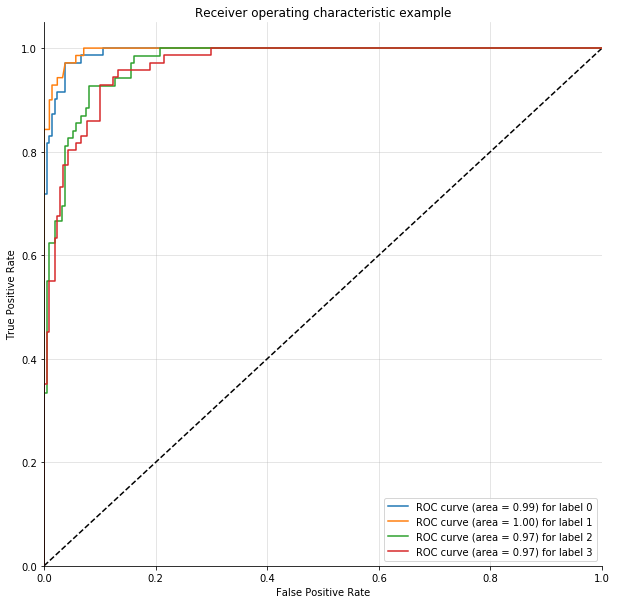

Subject :  2
Accuracy :  0.5971731448763251
Precision :  [0.43103448 0.53623188 0.71910112 0.64179104]
Recall :  [0.35211268 0.52112676 0.92753623 0.59722222]
Kappa score :  0.4632571913421065
ROC_AUC Score :  0.8198729120138859


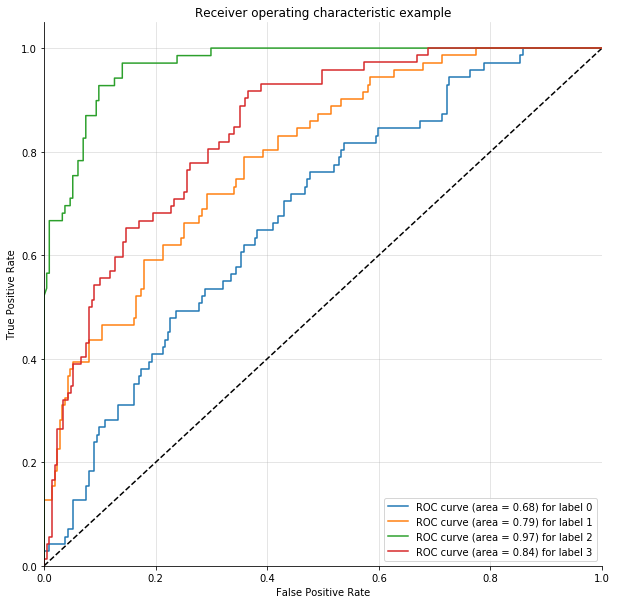

Subject :  3
Accuracy :  0.9340659340659341
Precision :  [0.89333333 0.98571429 0.89855072 0.96610169]
Recall :  [1.         0.98571429 0.91176471 0.83823529]
Kappa score :  0.912093023255814
ROC_AUC Score :  0.9870093368384475


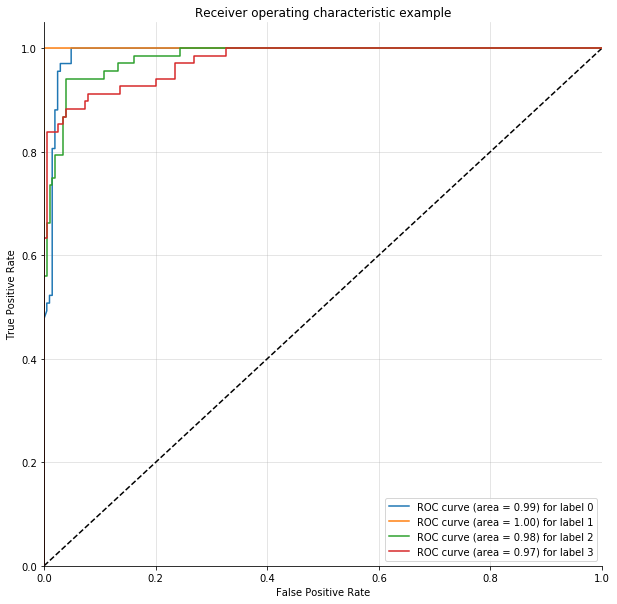

Subject :  4
Accuracy :  0.706140350877193
Precision :  [0.65625    0.64       0.80701754 0.71929825]
Recall :  [0.71186441 0.56140351 0.77966102 0.77358491]
Kappa score :  0.6080463899009596
ROC_AUC Score :  0.9034287164658242


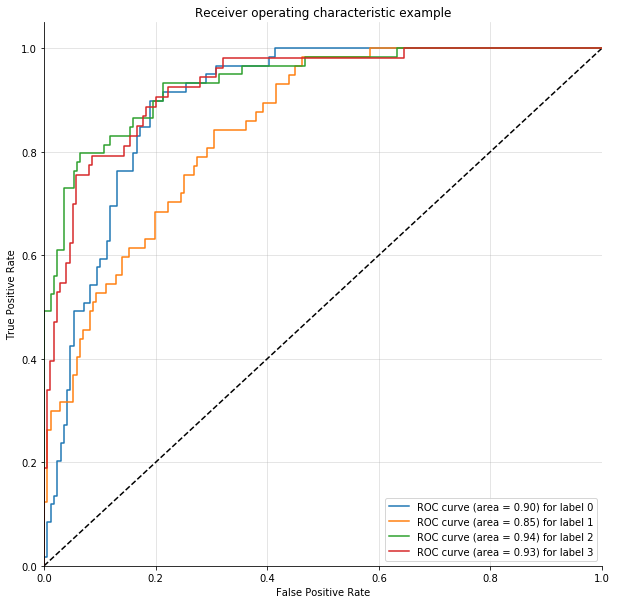

Subject :  5
Accuracy :  0.6666666666666666
Precision :  [0.73913043 0.75308642 0.5625     0.57692308]
Recall :  [0.72857143 0.93846154 0.375      0.65217391]
Kappa score :  0.5564173785441016
ROC_AUC Score :  0.8704861026960508


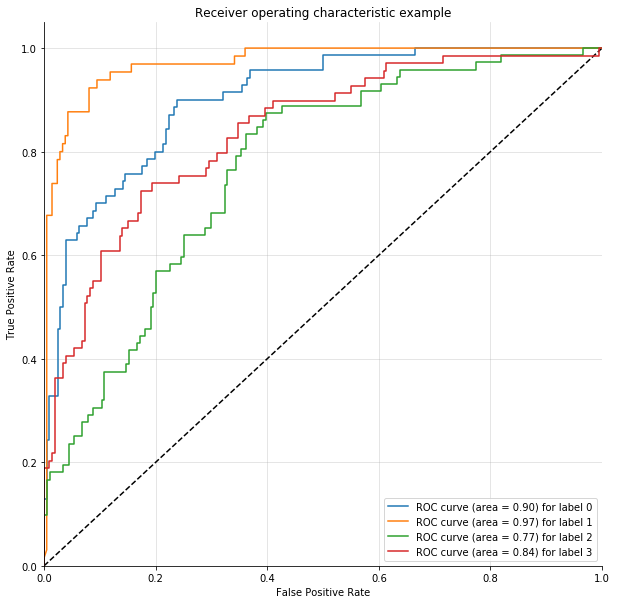

Subject :  6
Accuracy :  0.5767441860465117
Precision :  [0.57352941 0.46341463 0.73684211 0.55882353]
Recall :  [0.73584906 0.34545455 0.51851852 0.71698113]
Kappa score :  0.43632958801498123
ROC_AUC Score :  0.8174068706173431


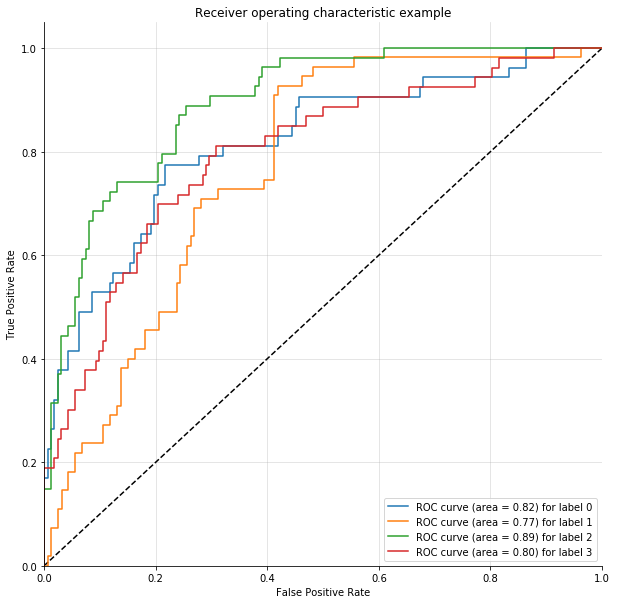

Subject :  7
Accuracy :  0.9097472924187726
Precision :  [0.984375   0.95774648 0.90909091 0.80263158]
Recall :  [0.88732394 0.98550725 0.84507042 0.92424242]
Kappa score :  0.8797409002500695
ROC_AUC Score :  0.9898604837072167


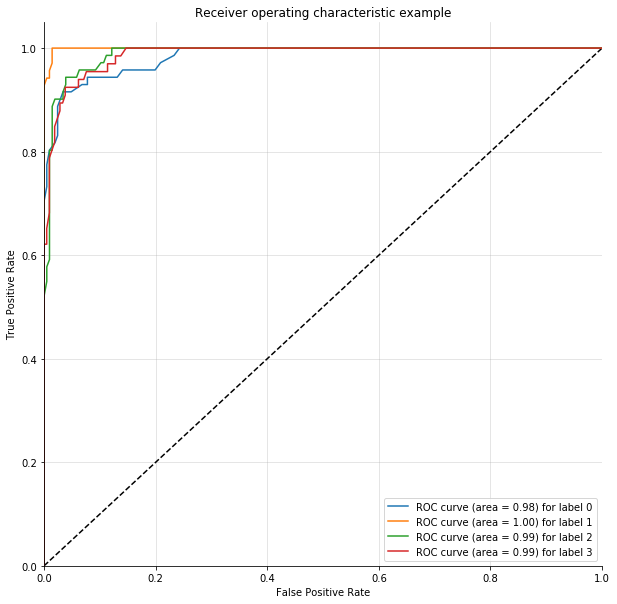

Subject :  8
Accuracy :  0.8413284132841329
Precision :  [0.92307692 0.875      0.80952381 0.7721519 ]
Recall :  [0.90909091 0.82352941 0.73913043 0.89705882]
Kappa score :  0.7884350036310821
ROC_AUC Score :  0.9608069659515475


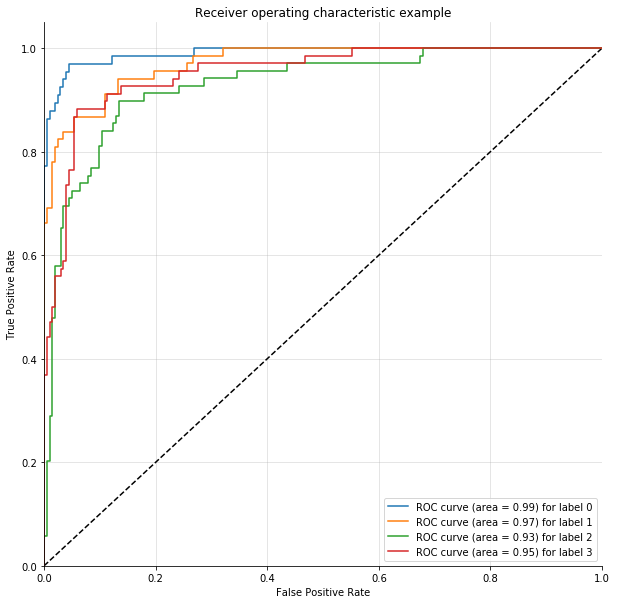

Subject :  9
Accuracy :  0.8257575757575758
Precision :  [0.96666667 0.85106383 0.79166667 0.74117647]
Recall :  [0.89230769 0.61538462 0.82608696 0.96923077]
Kappa score :  0.7675700505282499
ROC_AUC Score :  0.9629453678366723


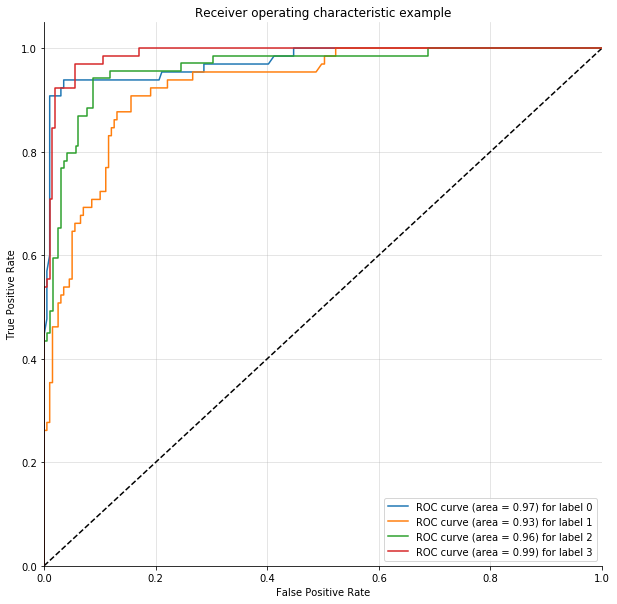

In [79]:
#SVC USING CSP
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    clf = RandomForestClassifier(max_depth=6, random_state=0)
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    print("Precision : ",precision_score(Y_test, y_pred,average=None))
    print("Recall : ",recall_score(Y_test, y_pred,average=None))
    print("Kappa score : ",cohen_kappa_score(y_pred,Y_test))
    probas_ = clf.predict_proba(X_test)
    print("ROC_AUC Score : ",roc_auc_score(Y_test, probas_, multi_class="ovo",average="weighted"))
    plot_multiclass_roc(i,clf, X_test, Y_test, n_classes=4, figsize=(10, 10))



In [82]:
import seaborn as sns
def plot_multiclass_roc(j,clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    i=j
    plt.savefig('WMA Subject %i.png' % (i))
    plt.show()


Subject :  1
Accuracy :  0.900355871886121
Confusion Matrix :  [[67  2  1  1]
 [ 1 69  0  0]
 [ 1  0 57 11]
 [ 1  0 10 60]]
Precision :  [0.95714286 0.97183099 0.83823529 0.83333333]
Recall :  [0.94366197 0.98571429 0.82608696 0.84507042]
Kappa score :  0.8671327490416604
ROC_AUC Score :  0.9098710093697813


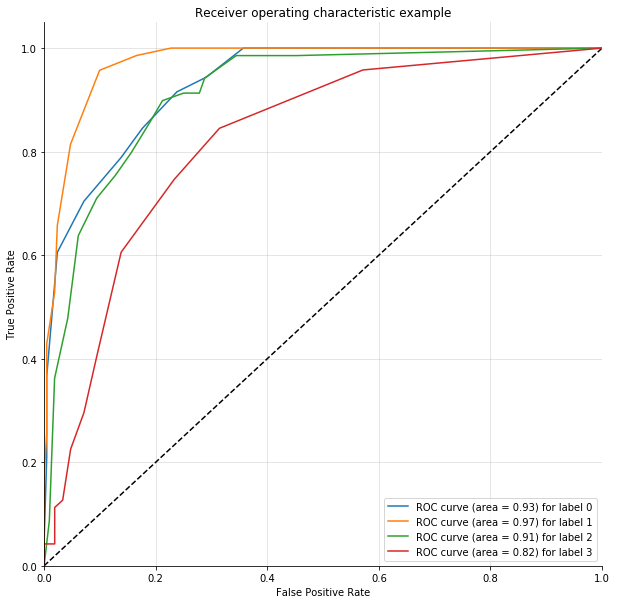

Subject :  2
Accuracy :  0.6325088339222615
Confusion Matrix :  [[30 16 11 14]
 [15 37  6 13]
 [ 1  2 65  1]
 [ 9 11  5 47]]
Precision :  [0.54545455 0.56060606 0.74712644 0.62666667]
Recall :  [0.42253521 0.52112676 0.94202899 0.65277778]
Kappa score :  0.5102421166486397
ROC_AUC Score :  0.8373912654786483


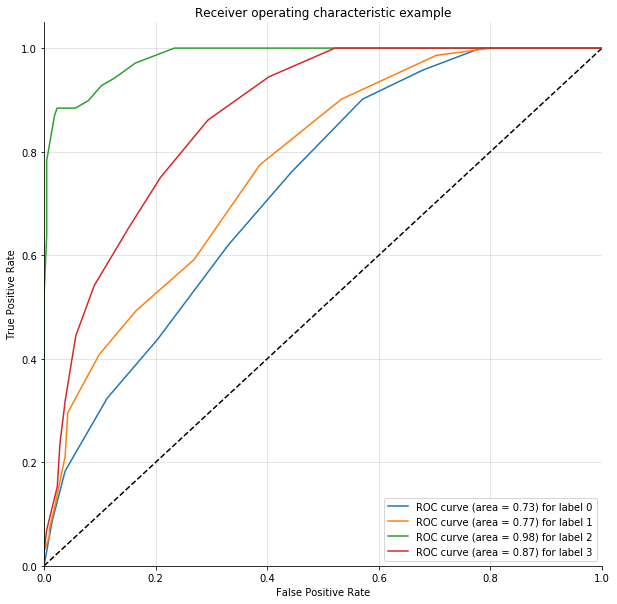

Subject :  3
Accuracy :  0.9010989010989011
Confusion Matrix :  [[66  0  0  1]
 [ 3 67  0  0]
 [ 3  0 57  8]
 [ 3  1  8 56]]
Precision :  [0.88       0.98529412 0.87692308 0.86153846]
Recall :  [0.98507463 0.95714286 0.83823529 0.82352941]
Kappa score :  0.8681489696622782
ROC_AUC Score :  0.8503918272245752


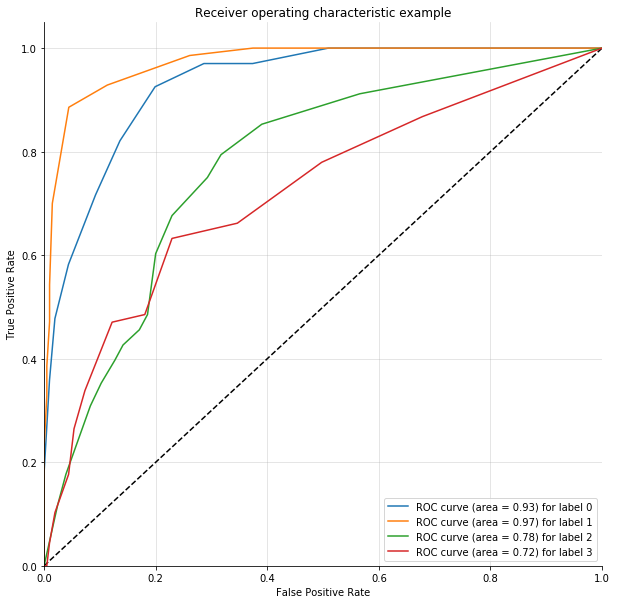

Subject :  4
Accuracy :  0.7456140350877193
Confusion Matrix :  [[42 12  5  0]
 [ 9 44  3  1]
 [ 1  1 43 14]
 [ 3  7  2 41]]
Precision :  [0.76363636 0.6875     0.81132075 0.73214286]
Recall :  [0.71186441 0.77192982 0.72881356 0.77358491]
Kappa score :  0.6608882962355114
ROC_AUC Score :  0.8808717401882596


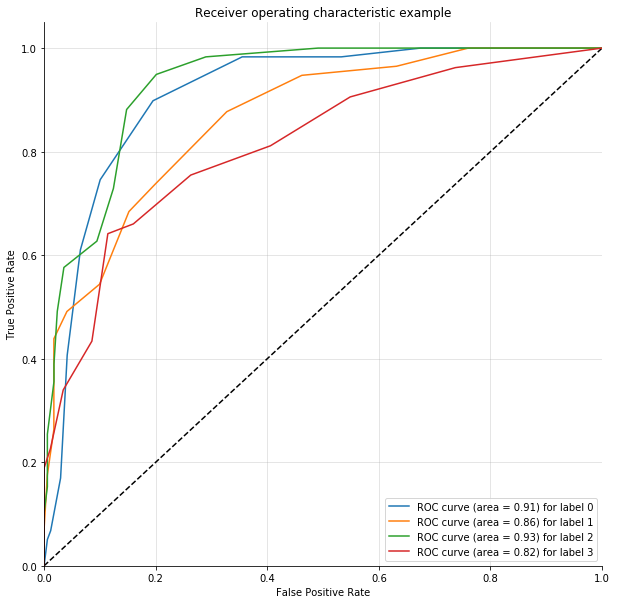

Subject :  5
Accuracy :  0.7572463768115942
Confusion Matrix :  [[59  6  3  2]
 [ 2 61  2  0]
 [ 8 10 38 16]
 [10  2  6 51]]
Precision :  [0.74683544 0.7721519  0.7755102  0.73913043]
Recall :  [0.84285714 0.93846154 0.52777778 0.73913043]
Kappa score :  0.6768375799517667
ROC_AUC Score :  0.7640099812073268


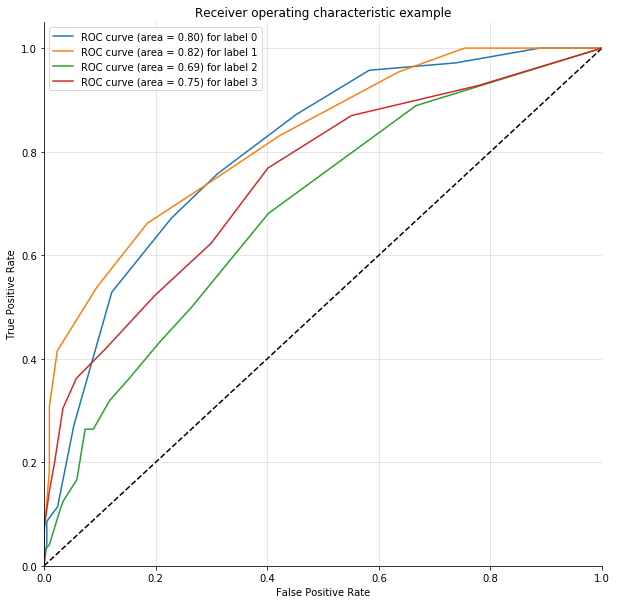

Subject :  6
Accuracy :  0.6186046511627907
Confusion Matrix :  [[35  7  3  8]
 [14 30  4  7]
 [ 6  6 32 10]
 [ 9  7  1 36]]
Precision :  [0.546875   0.6        0.8        0.59016393]
Recall :  [0.66037736 0.54545455 0.59259259 0.67924528]
Kappa score :  0.4917843759008359
ROC_AUC Score :  0.7341637229395018


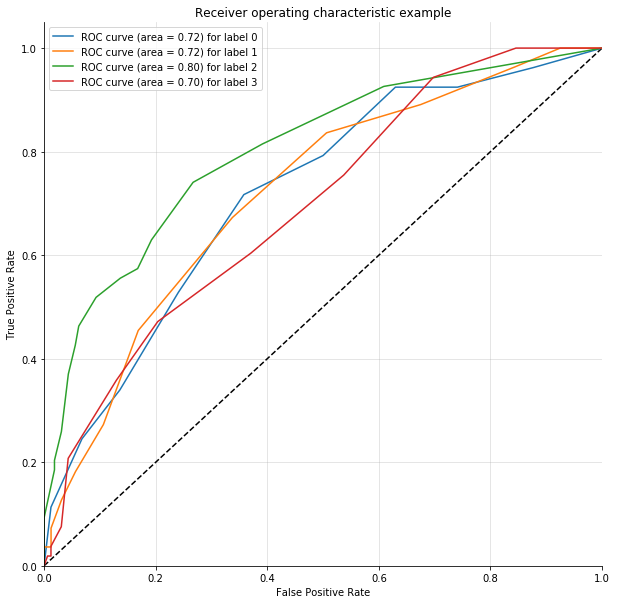

Subject :  7
Accuracy :  0.9494584837545126
Confusion Matrix :  [[70  0  0  1]
 [ 0 69  0  0]
 [ 0  0 62  9]
 [ 0  0  4 62]]
Precision :  [1.         1.         0.93939394 0.86111111]
Recall :  [0.98591549 1.         0.87323944 0.93939394]
Kappa score :  0.9326268241834608
ROC_AUC Score :  0.8654983689899274


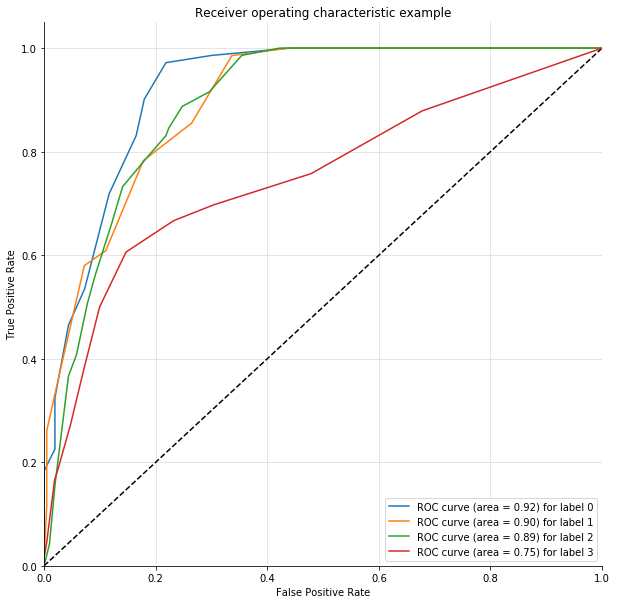

Subject :  8
Accuracy :  0.8819188191881919
Confusion Matrix :  [[64  0  1  1]
 [ 0 63  1  4]
 [ 3  4 51 11]
 [ 3  2  2 61]]
Precision :  [0.91428571 0.91304348 0.92727273 0.79220779]
Recall :  [0.96969697 0.92647059 0.73913043 0.89705882]
Kappa score :  0.8426077171585176
ROC_AUC Score :  0.9119554385790313


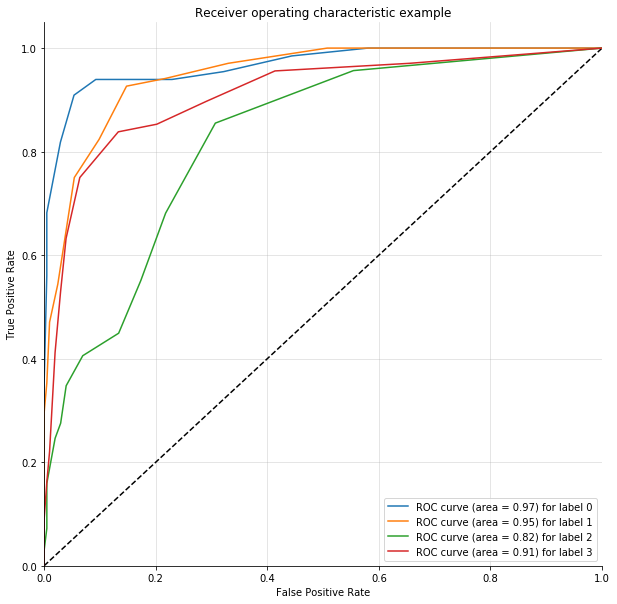

Subject :  9


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy :  0.8484848484848485
Confusion Matrix :  [[58  5  2  0]
 [ 3 46  8  8]
 [ 1  6 56  6]
 [ 0  1  0 64]]
Precision :  [0.93548387 0.79310345 0.84848485 0.82051282]
Recall :  [0.89230769 0.70769231 0.8115942  0.98461538]
Kappa score :  0.797979797979798
ROC_AUC Score :  0.8369358298706123


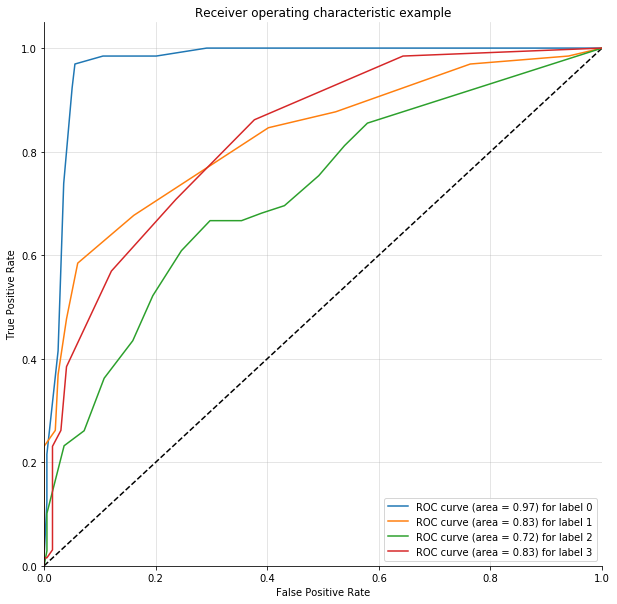

Average Accuracy :  0.8039212023774378


In [84]:
#WMA USING CSP - Weighted Majority Algorithm
sum = 0
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate = 0.05, max_features=10, max_depth = 2, random_state = 0)
    clf4 = RandomForestClassifier(random_state=101)
    eclf = EnsembleVoteClassifier(clfs=[ clf1, clf2,clf4], weights=[1,1,1])
    eclf.fit(X_train,Y_train)
    y_pred = eclf.predict(X_test)
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    print("Confusion Matrix : ",confusion_matrix(Y_test,y_pred))
    print("Precision : ",precision_score(Y_test, y_pred,average=None))
    print("Recall : ",recall_score(Y_test, y_pred,average=None))
    print("Kappa score : ",cohen_kappa_score(y_pred,Y_test))
    probas_ = clf.predict_proba(X_test)
    print("ROC_AUC Score : ",roc_auc_score(Y_test, probas_, multi_class="ovo",average="weighted"))
    plot_multiclass_roc(i,clf, X_test, Y_test, n_classes=4, figsize=(10, 10))
    sum = sum+accuracy_score(Y_test,y_pred)
print("Average Accuracy : ",sum/9)


In [85]:
#WMA USING CSP
from sklearn.ensemble import VotingClassifier
sum = 0
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate = 0.05, max_features=10, max_depth = 2, random_state = 0)
    clf4 = RandomForestClassifier(random_state=101)
    voting_clf = VotingClassifier(estimators=[('MLR', clf1), ('GBC', clf2), ('RF', clf4)], voting='hard')
    voting_clf.fit(X_train,Y_train)
    y_pred = voting_clf.predict(X_test)
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    sum = sum+accuracy_score(Y_test,y_pred)
print("Average Accuracy : ",sum/9)


Subject :  1
Accuracy :  0.900355871886121
Subject :  2
Accuracy :  0.6325088339222615
Subject :  3
Accuracy :  0.9010989010989011
Subject :  4
Accuracy :  0.7456140350877193
Subject :  5
Accuracy :  0.7572463768115942
Subject :  6
Accuracy :  0.6186046511627907
Subject :  7
Accuracy :  0.9494584837545126
Subject :  8
Accuracy :  0.8819188191881919
Subject :  9


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy :  0.8484848484848485
Average Accuracy :  0.8039212023774378


In [2]:
!pip install DESlib

In [17]:
#KNORAE USING CSP
from deslib.des.knora_e import KNORAE
sum = 0
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    # Train a pool of 10 classifiers
    pool_classifiers = RandomForestClassifier(n_estimators=10)
    pool_classifiers.fit(X_train, Y_train)
    # Initialize the DES model
    knorae = KNORAE(pool_classifiers)
    knorae.fit(X_test, Y_test)
    y_pred = knorae.predict(X_test)
    
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    print("Confusion Matrix : ",confusion_matrix(Y_test,y_pred))
    print("Precision : ",precision_score(Y_test, y_pred,average=None))
    print("Recall : ",recall_score(Y_test, y_pred,average=None))
    print("Kappa score : ",cohen_kappa_score(y_pred,Y_test))
    probas_ = knorae.predict_proba(X_test)
    print("ROC_AUC Score : ",roc_auc_score(Y_test, probas_, multi_class="ovo",average="weighted"))
    sum = sum+accuracy_score(Y_test,y_pred)
print("Average Accuracy : ",sum/9)


Subject :  1
Accuracy :  1.0
Confusion Matrix :  [[71  0  0  0]
 [ 0 70  0  0]
 [ 0  0 69  0]
 [ 0  0  0 71]]
Precision :  [1. 1. 1. 1.]
Recall :  [1. 1. 1. 1.]
Kappa score :  1.0
ROC_AUC Score :  1.0
Subject :  2
Accuracy :  0.9575971731448764
Confusion Matrix :  [[64  2  2  3]
 [ 1 69  1  0]
 [ 0  2 67  0]
 [ 0  0  1 71]]
Precision :  [0.98461538 0.94520548 0.94366197 0.95945946]
Recall :  [0.90140845 0.97183099 0.97101449 0.98611111]
Kappa score :  0.9434603090037293
ROC_AUC Score :  0.9781047917842259
Subject :  3
Accuracy :  0.9963369963369964
Confusion Matrix :  [[67  0  0  0]
 [ 0 70  0  0]
 [ 0  0 67  1]
 [ 0  0  0 68]]
Precision :  [1.         1.         1.         0.98550725]
Recall :  [1.         1.         0.98529412 1.        ]
Kappa score :  0.995115580047234
ROC_AUC Score :  0.9981640091934209
Subject :  4
Accuracy :  0.9780701754385965
Confusion Matrix :  [[58  1  0  0]
 [ 1 56  0  0]
 [ 1  0 58  0]
 [ 1  0  1 51]]
Precision :  [0.95081967 0.98245614 0.98305085 1.      

KeyboardInterrupt: 

In [22]:
#KNORAE USING CSP
from deslib.des.knora_e import KNORAE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier
sum = 0
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    # Train a pool of 10 classifiers
    model = CalibratedClassifierCV(Perceptron(max_iter=10))
    pool_classifiers = BaggingClassifier(model, n_estimators=10)
    pool_classifiers.fit(X_train, Y_train)
    # Initialize the DES model
    knorae = KNORAE(pool_classifiers)
    knorae.fit(X_train, Y_train)
    y_pred = knorae.predict(X_test)
    
    print("Accuracy : ",accuracy_score(Y_test, y_pred))
    print("Confusion Matrix : ",confusion_matrix(Y_test,y_pred))
    sum = sum+accuracy_score(Y_test,y_pred)
print("Average Accuracy : ",sum/9)


Subject :  1


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

Accuracy :  0.8932384341637011
Confusion Matrix :  [[66  4  1  0]
 [ 4 65  1  0]
 [ 1  0 61  7]
 [ 0  1 11 59]]
Subject :  2


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

Accuracy :  0.6219081272084805
Confusion Matrix :  [[30 17 10 14]
 [19 39  3 10]
 [ 2  0 66  1]
 [ 9 13  9 41]]
Subject :  3


C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increas

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true

Accuracy :  0.8131868131868132
Confusion Matrix :  [[65  1  1  0]
 [ 3 65  2  0]
 [ 7  1 51  9]
 [10  0 17 41]]
Subject :  4


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarn

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\si

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

Accuracy :  0.6885964912280702
Confusion Matrix :  [[44 11  3  1]
 [18 36  2  1]
 [ 4  1 47  7]
 [ 3 12  8 30]]
Subject :  5


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\si

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true

Accuracy :  0.7210144927536232
Confusion Matrix :  [[54  6  9  1]
 [ 3 57  4  1]
 [ 5 10 41 16]
 [11  5  6 47]]
Subject :  6


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increas

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increas

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increas

Accuracy :  0.5302325581395348
Confusion Matrix :  [[31  6  6 10]
 [14 22  8 11]
 [ 9  3 31 11]
 [13  7  3 30]]
Subject :  7


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

Accuracy :  0.9350180505415162
Confusion Matrix :  [[71  0  0  0]
 [ 9 59  1  0]
 [ 0  0 69  2]
 [ 0  2  4 60]]
Subject :  8


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

Accuracy :  0.8634686346863468
Confusion Matrix :  [[65  0  1  0]
 [ 0 65  1  2]
 [ 7  5 46 11]
 [ 4  4  2 58]]
Subject :  9


C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarn

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anacond

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encountered in multiply
  return (sample_weight * loss).sum()
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:449: RuntimeWarning: invalid value encount

C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]
C:\Users\admin\anaconda3\lib\site-packages\sklearn\calibration.py:394: RuntimeWarning: invalid value encountered in true_divide
  proba /= np.sum(proba, axis=1)[:, np.newaxis]


Accuracy :  0.7954545454545454
Confusion Matrix :  [[57  5  3  0]
 [10 35  9 11]
 [ 3  3 57  6]
 [ 0  1  3 61]]
Average Accuracy :  0.7624575719291814


In [ ]:
#WMA USING CSP
sum = 0
for i in range(1,10):
    print("Subject : ",i)
    train_data,train_label = get_data(i,True,'IV-2a-master/dataset/')
    eval_data,eval_label = get_data(i,False,'IV-2a-master/dataset/')
    w=generate_projection(train_data,train_label,NO_csp,filter_bank,time_windows)
    X_train=extract_feature(train_data,w,filter_bank,time_windows)
    X_test=extract_feature(eval_data,w,filter_bank,time_windows)
    Y_train=train_label
    Y_test=eval_label
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
    clf2 = GradientBoostingClassifier(n_estimators=1000, learning_rate = 0.05, max_features=10, max_depth = 2, random_state = 0)
    clf4 = RandomForestClassifier(random_state=101)
    eclf = EnsembleVoteClassifier(clfs=[ clf1, clf2,clf4], weights=[1,2,1])
    eclf.fit(X_train,Y_train)
    y_pred = eclf.predict(X_test)
    print("Accuracy : ",accuracy_score(Y_test, y_pred))

    sum = sum+accuracy_score(Y_test,y_pred)
print("Average Accuracy : ",sum/9)


Subject :  1
Accuracy :  0.900355871886121
Subject :  2
Accuracy :  0.6254416961130742
Subject :  3
Accuracy :  0.9047619047619048
Subject :  4
